In [1]:
%%capture
!pip install ../opt

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [24, 16]

In [3]:
def f1(v):
    return v[0] ** 2 + v[1] ** 2

def f3(v):
    return 0.26 * (v[0] ** 2 + v[1] ** 2) - 0.48 * v[0] * v[1]

**Booth's function**
$\\$
$f(x, y) = (x + 2y - 7)^2 + (2x + y - 5)^2 \\ f(1, 3) = 0 \\ -10 \leqslant x, y \leqslant 10$

In [4]:
def f2(v):
    return (v[0] + 2 * v[1] - 7) ** 2 + (2 * v[0] + v[1] - 5) ** 2

<center>
$\displaystyle \nabla f(\boldsymbol{x}) =
\begin{pmatrix} \displaystyle \frac{\partial f}{\partial x_1}\\ \displaystyle \frac{\partial f}{\partial
x_2}\\ \vdots\\ \displaystyle \frac{\partial f}{\partial x_n} \end{pmatrix}$
</center>

<center>
$\displaystyle {\frac  {\partial f}{\partial x_{k}}}(x_{1},\cdots ,x_{n})=\lim _{{\Delta x\to 0}}{\frac  {f(x_{1},\ldots ,x_{k}+\Delta x,\ldots ,x_{n})-f(x_{1},\ldots ,x_{k},\ldots ,x_{n})}{\Delta x}}.$
</center>

In [5]:
delta_x = 1e-6


def derivative(f, v, i):
    upd_v = np.copy(v)
    upd_v[i] += delta_x
    return (f(upd_v) - f(v)) / delta_x


def gradient(f, v):
    return np.array([derivative(f, v, i) for i in range(len(v))])

In [6]:
def painter_decorator3d(func):
    def draw(*args, **kwargs):
        xk = func(*args, **kwargs)
        function = kwargs.get("f") if kwargs.get("f") else args[0]
        xx = xk[:, 0]
        yy = xk[:, 1]
        zz = function(xk.T)

        lim = max(max(xx), max(yy))
        x = np.linspace(-lim, lim, 500)
        y = np.linspace(-lim, lim, 500)
        x, y = np.meshgrid(x, y)
        z = function(np.array([x, y]))

        figure = plt.figure()
        figure.patch.set_facecolor('w')
        std_view = figure.add_subplot(1, 2, 1, projection='3d')
        std_view.contour(x, y, z, 200, alpha=.7)
        std_view.scatter(xx, yy, zz, color='white', cmap=None, s=30, alpha=.8)
        std_view.plot(xx, yy, zz, color='white', alpha=.9, linestyle='--')
        std_view.axis('off')

        upper_view = figure.add_subplot(1, 2, 2, projection='3d')
        upper_view.contour(x, y, z, 200, alpha=.7)
        upper_view.scatter(xx, yy, zz, color='white', s=30, alpha=.8)
        upper_view.plot(xx, yy, zz, color='white', linestyle='--')
        upper_view.view_init(90, 0)
        upper_view.axis('off')
        print(f'Iterations: {len(xk) - 1}, result: {np.append(xk[-1], zz[-1])}')

    return draw

## 1. Gradient descent with constant learning rate

In [7]:
@painter_decorator3d
def gradient_descent_const(f, x0, learning_rate, tolerance=1e-5, n_iter=100):
    xk = np.array([x0], dtype=float)
    for _ in range(n_iter):
        step = -learning_rate * gradient(f, xk[-1])
        if np.all(np.abs(step) < tolerance):
            break

        xk1 = xk[-1] + step
        xk = np.append(xk, np.array([xk1]), axis=0)

    return xk

### Optimal learning rate

Iterations: 26, result: [1.65581737e-05 1.65581737e-05 5.48346232e-10]


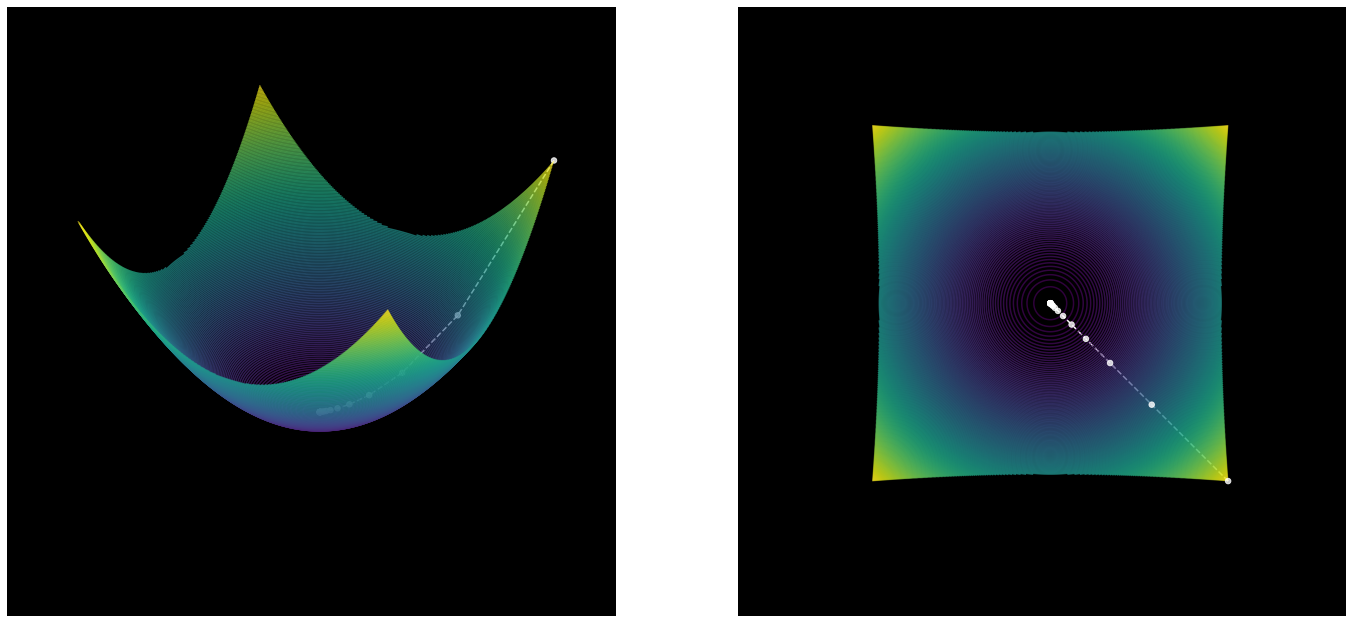

In [8]:
gradient_descent_const(f1, np.array([10, 10], dtype=float), 0.2)

### Large learning rate

Iterations: 26, result: [1.65581737e-05 1.65581737e-05 5.48346232e-10]


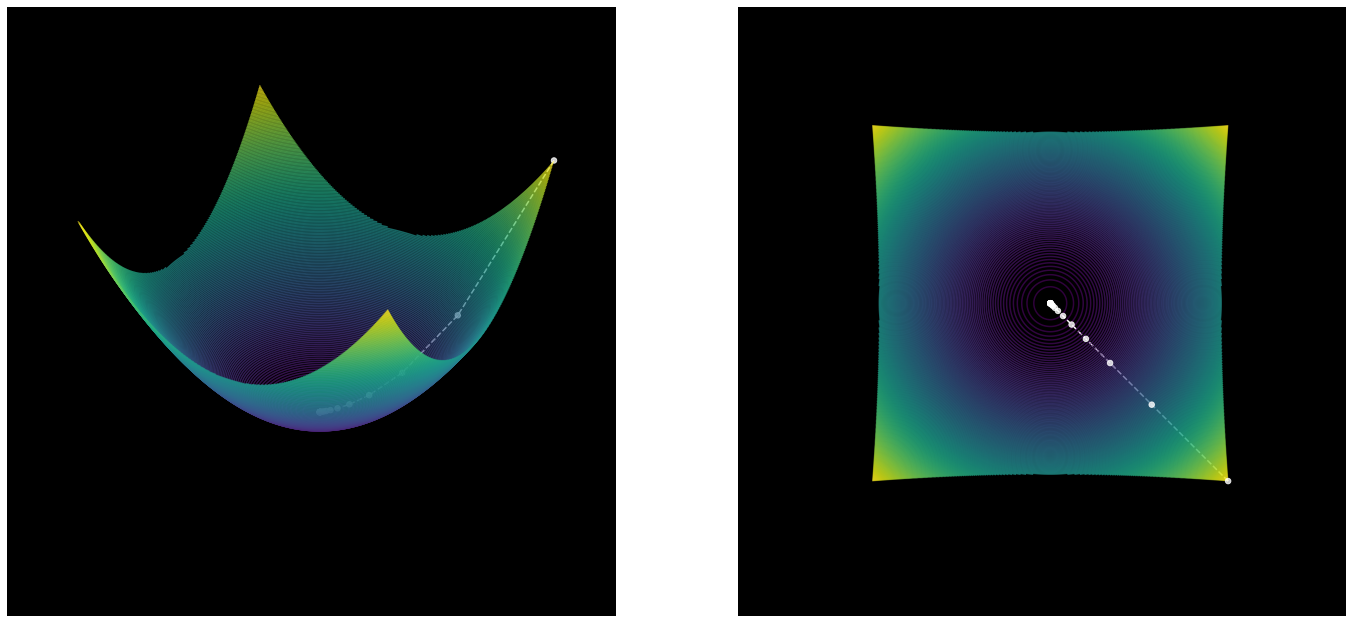

In [9]:
gradient_descent_const(f1, np.array([10, 10], dtype=float), 0.2)

### Small learning rate

Iterations: 100, result: [1.32619513 1.32619513 3.51758702]


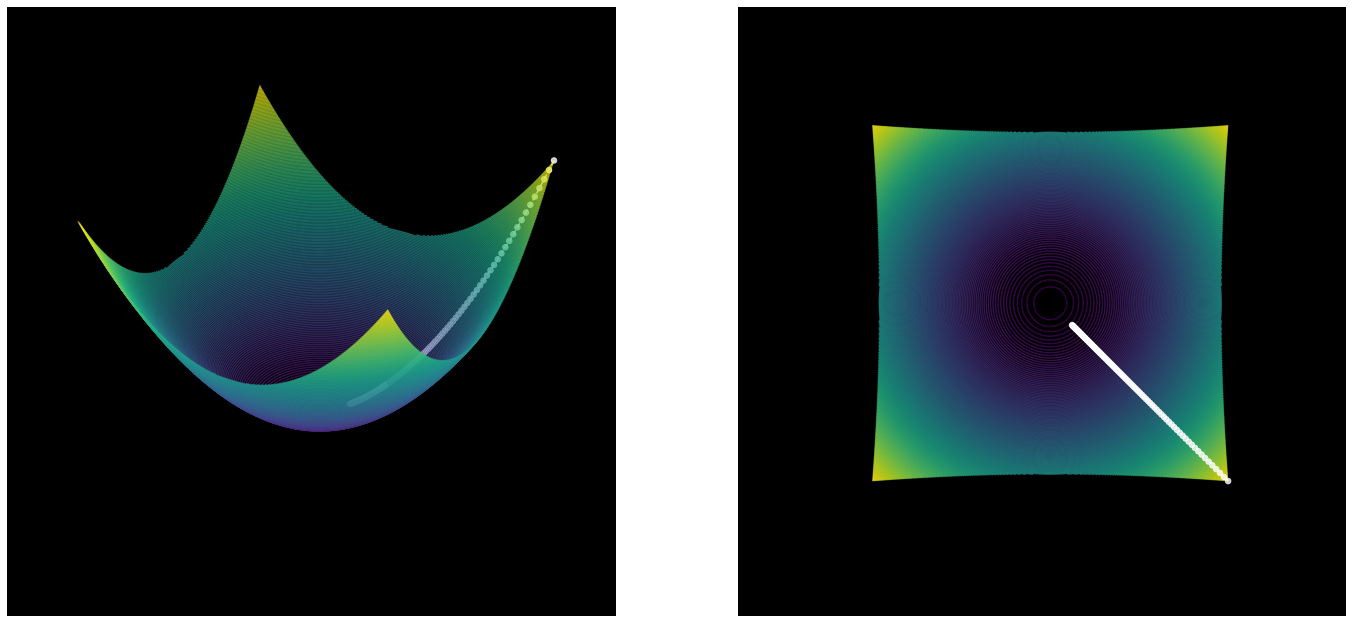

In [10]:
gradient_descent_const(f1, np.array([10, 10], dtype=float), 0.01)

## 2. Gradient descent with "step crushing" - метод дробления шага

$\displaystyle f(x^{k+1}) = f(x^k - \lambda^{k}\nabla f(x^k)) \leqslant f(x^k) - \varepsilon \lambda^{k} \Vert \nabla f(x^k) \Vert^2$

$\displaystyle \varepsilon \in (0, 1)$

In [11]:
# need fix





@painter_decorator3d
def gradient_descent_step_crushing(f, x0, learning_rate=1, tolerance=1e-6, n_iter=100, eps=0.1):
    xk = np.array([x0], dtype=float)
    fxk = f(x0)

    for i in range(n_iter):
        step = -learning_rate * gradient(f, xk[-1])
        print(step)
        if np.all(np.abs(step) < tolerance):
            break

        xk1 = xk[-1] + step
        fxk1 = f(xk1)
        if fxk1 - fxk > -eps * learning_rate * (np.linalg.norm(xk[-1], 2) ** 2):
            learning_rate *= .5
            i -= 1
            continue

        xk = np.append(xk, np.array([xk1]), axis=0)
        fxk = fxk1
    return xk

[-10.00000026   9.99999973]
[-2.53415258e-07 -2.45552677e-07]
Iterations: 1, result: [-2.58969521e-07 -2.66832103e-07  2.78012853e-15]


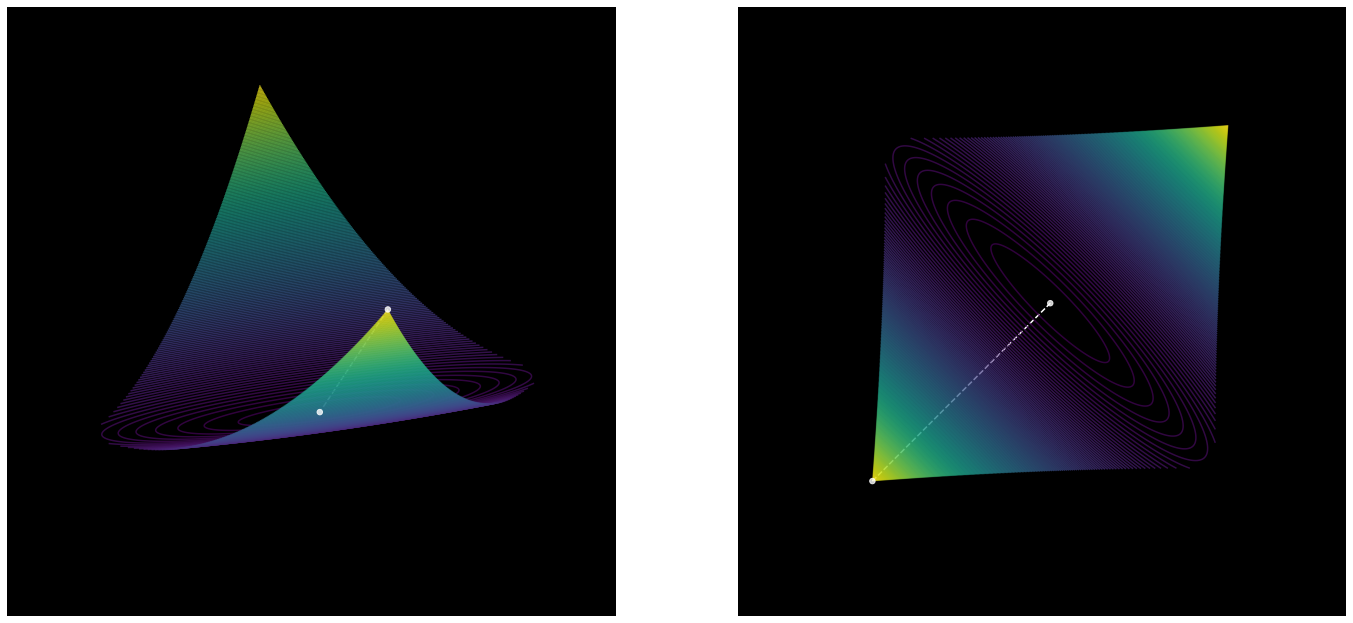

In [12]:
gradient_descent_step_crushing(f3, np.array([10, -10], dtype=float), 1)

## 3. Gradient descent with 1D optimization techniques

$\displaystyle \lambda^k = arg_{\lambda \in [0, +\inf)} min \ f(x^k - \lambda \nabla f(x^k))$

In [13]:
from opt_algo.opt_1d import *


@painter_decorator3d
def gradient_descent_opt1d(f, opt_method, x0, tolerance=1e-4, n_iter=100):
    xk = np.array([x0], dtype=float)
    l, r = 0, 1e6
    for _ in range(n_iter):
        learning_rate = opt_method(lambda lr: f(xk[-1] - lr * gradient(f, xk[-1])), l, r, eps=tolerance)
        step = -learning_rate * gradient(f, xk[-1])
        if np.all(np.abs(step) < tolerance):
            break

        xk1 = xk[-1] + step
        xk = np.append(xk, np.array([xk1]), axis=0)
    return xk

Iterations: 1, result: [-4.70460499e-05  4.65202458e-05  2.18866569e-09]


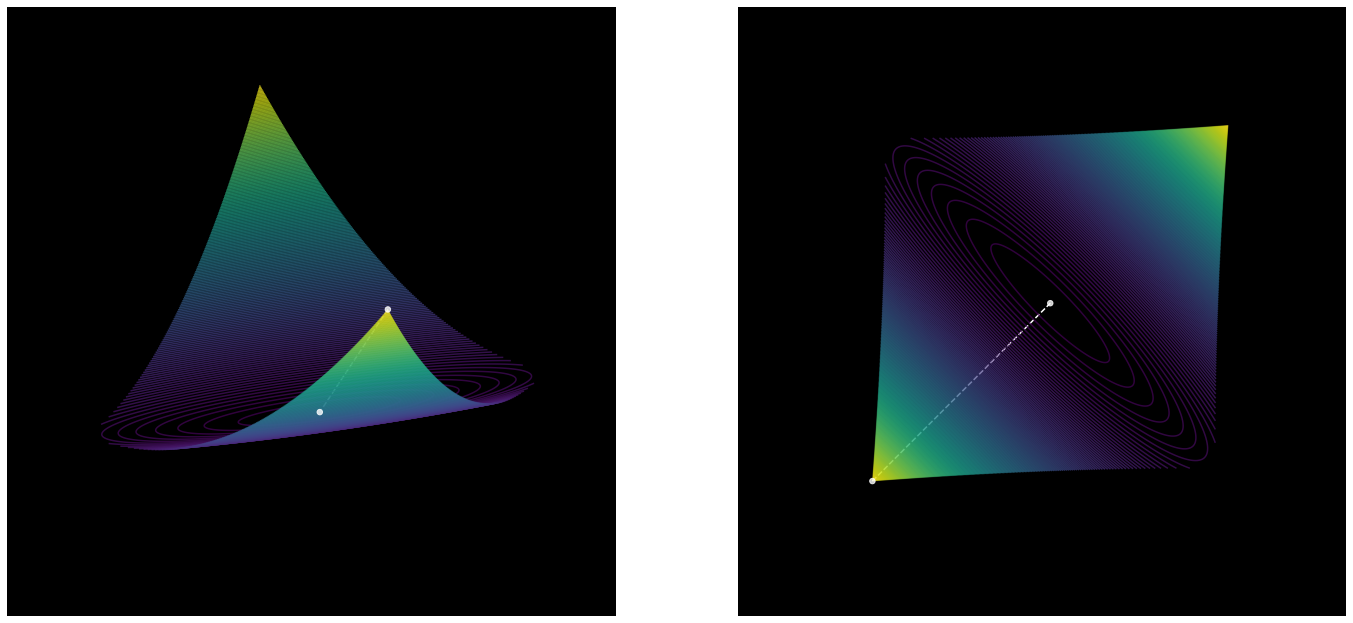

In [17]:
gradient_descent_opt1d(f3, golden_section_search, np.array([10, -10], dtype=float))

Iterations: 6, result: [1.00000135e+00 3.00000106e+00 2.61591642e-11]


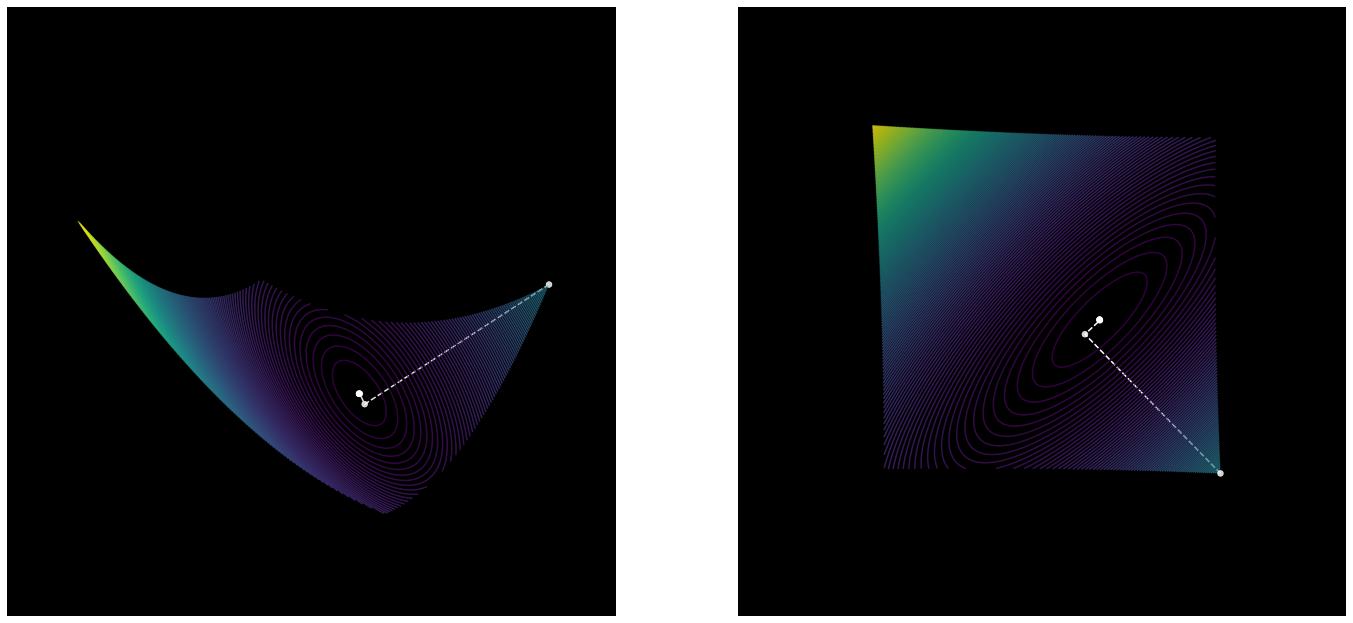

In [15]:
gradient_descent_opt1d(f2, golden_section_search, np.array([10, 10], dtype=float))